In [13]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image

import argparse
import os

import numpy as np
import matplotlib.pyplot as plt

from utils import setBoundaries, makeSamples, PhysicalLoss
from solve import solve as solve2
from glob import glob

from networks import UNet, GrowingUNet, VariableLossUNet

In [24]:
import numpy as np
from scipy.ndimage import zoom
from scipy.signal import convolve2d

def solve(initial, fixed, tol=1e-15, warm_start=None, ground_truth=None, initialization='constant'):
    """Simulate heat diffusion to identify the steady state.

    Parameters
    ----------
    initial: float array
      the initial temperate at every point in the grid
    fixed: bool array
      elements that are set to True will be kept fixed and not allowed to change
    tol: float
      iteration continues until no element changes by more than this
    """
    mask = np.array([[0, 0.25, 0], [0.25, 0.0, 0.25], [0, 0.25, 0]])
    fixed_values = initial[fixed]
    width = initial.shape[0]
    if warm_start is not None:
        array = warm_start
    else:
        if initialization == 'hierarchical':
            # Start by solving a scaled down version of the grid, then use that
            # as the initial guess.  This can lead to much faster convergence.

            x, y = np.where(fixed)
            small_initial = zoom(initial, 0.25)
            small_initial[x//4, y//4] = fixed_values
            small_fixed = np.zeros(small_initial.shape, dtype=np.bool)
            small_fixed[x//4, y//4] = True
            small_solution = solve2(small_initial, small_fixed, tol)
            array = zoom(small_solution, 4.0)
        else:
            array = np.ones(initial.shape) * np.mean(fixed_values)

    array[fixed] = fixed_values

    # Iterate until convergence is reached.
    iterations = 0
    error = []
    while True:
        iterations += 1
        if ground_truth is not None:
            error.append(np.linalg.norm((array - ground_truth).flatten()) / len(ground_truth.flatten()))
        new_array = convolve2d(array, mask, mode='same', boundary='symm')
        new_array[fixed] = fixed_values
        change = np.max(np.abs(array-new_array))
        if change <= tol:
            return array, error
        array = new_array

In [5]:
batch_size=1; cuda=True; epoch_size=300; epochs=256; experiment='run0'; growing=True
image_size=256; learning_rate=0.0002; manualSeed=None; start_size=4

# Set up CUDA
if cuda and torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
else:
    if torch.cuda.is_available():
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
    dtype = torch.FloatTensor


In [6]:
files = glob(experiment+"/*.pth")
maximum = 0
for file in files:
    maximum = max(int(file.split("_")[-1].split(".")[0]), maximum)
file = glob(experiment + "/*" + str(maximum) + ".pth")[0]
print(file)
net = UNet(dtype, image_size=image_size).type(dtype)

state_dict = torch.load(file)
# state_dict = torch.load(file, map_location=lambda storage, loc: storage.cuda(1))
net.load_state_dict(state_dict)
print(net)

run0/net_epoch_127.pth
UNet(
  (encoding_layers): ModuleList(
    (0): Conv2d (1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Conv2d (64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): Conv2d (128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Conv2d (256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Conv2d (512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Conv2d (512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): Conv2d (512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Conv2d (512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (encoding_bns): ModuleList(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (4): BatchNorm2d(512, eps

Test Example: 0
Solving Ground Truth (high precision)
Solving Finite Difference (cold start)
Solving Warm Start


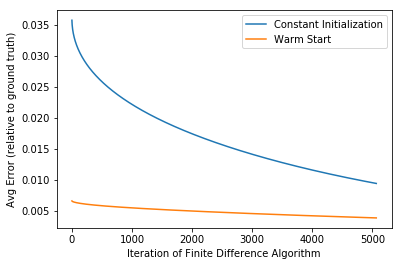

Test Example: 1
Solving Ground Truth (high precision)
Solving Finite Difference (cold start)
Solving Warm Start


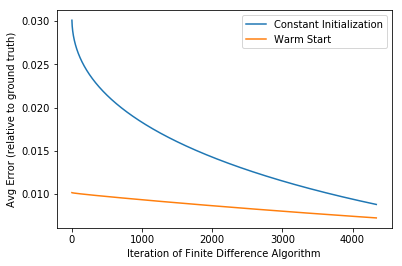

Test Example: 2
Solving Ground Truth (high precision)
Solving Finite Difference (cold start)
Solving Warm Start


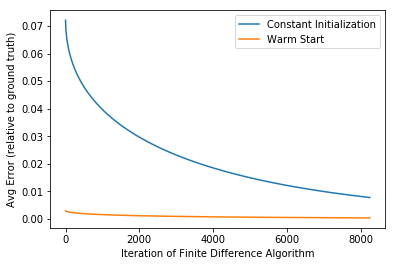

Test Example: 3
Solving Ground Truth (high precision)
Solving Finite Difference (cold start)
Solving Warm Start


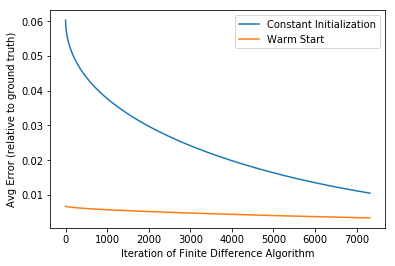

Test Example: 4
Solving Ground Truth (high precision)
Solving Finite Difference (cold start)
Solving Warm Start


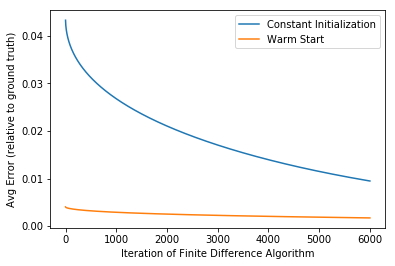

error:  1.3728072916395075


In [27]:
num_test = 5

physical_loss = PhysicalLoss(dtype)

boundary = np.zeros((image_size, image_size), dtype=np.bool)
boundary[0,:] = True
boundary[-1,:] = True
boundary[:,0] = True
boundary[:,-1] = True

data = torch.zeros(1,1,image_size,image_size)
error = []
for i in range(num_test):
    data[:,:,:,0] = np.random.uniform(100)
    data[:,:,0,:] = np.random.uniform(100)
    data[:,:,:,-1] = np.random.uniform(100)
    data[:,:,-1,:] = np.random.uniform(100)

    img = Variable(data).type(dtype)
    output = net(img)
    output = output.cpu().data.numpy()[0,0,:,:]

    print("Test Example: %d"%i)

    data_cpu = data.cpu().numpy()[0,0,:,:]
    
    print("Solving Ground Truth (high precision)")
    # True solution to high precision
    ground_truth = solve2(data_cpu, boundary, tol=1e-7)

#     print("Solving Hierarchical")
#     solution_H, errors_H = solve(data_cpu, boundary, tol=1e-3, ground_truth=ground_truth, initialization='hierarchical')
    print("Solving Finite Difference (cold start)")
    solution_FD, errors_FD = solve(data_cpu, boundary, tol=1e-3, ground_truth=ground_truth)
    print("Solving Warm Start")
    solution_WS, errors_WS = solve(data_cpu, boundary, tol=1e-2, warm_start=output, ground_truth=ground_truth)
    
    plt.plot(errors_FD, label='Constant Initialization')
    plt.plot(errors_WS[:len(errors_FD)], label='Warm Start')
#     plt.plot(errors_H[:min(len(errors_FD),len(errors_H))], label='Hierarchical')
    plt.legend()
    plt.ylabel("Avg Error (relative to ground truth)")
    plt.xlabel("Iteration of Finite Difference Algorithm")
    plt.show()

    error.append(np.mean(np.abs(output-ground_truth))) 
#     # Plot real samples
#     plt.figure(figsize=(15, 25))
#     XX, YY = np.meshgrid(np.arange(0, image_size), np.arange(0, image_size))
#     plt.subplot(3,1,1)
#     plt.contourf(XX, YY, data.cpu().numpy()[0,0,:,:], colorinterpolation=50, vmin=0, vmax=100, cmap=plt.cm.jet)
#     plt.title("Initial Condition")
#     plt.axis('equal')
#     plt.subplot(3,1,2)
#     plt.contourf(XX, YY, solution, colorinterpolation=50, vmin=0, vmax=100, cmap=plt.cm.jet)
#     plt.title("Equilibrium Condition")
#     plt.axis('equal')
#     plt.subplot(3,1,3)
#     plt.contourf(XX, YY, output, colorinterpolation=50, vmin=0, vmax=100, cmap=plt.cm.jet)
#     plt.title("Learned Output")
#     plt.axis('equal')
#     plt.show()

error = np.array(error)
print("error: ", np.mean(error))